## Constants

In [1]:
import os

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'  # this is required
os.environ['CUDA_VISIBLE_DEVICES'] = '0'         # set to '0' for GPU0, '1' for GPU1 or '2' for GPU2. Check "gpustat" in a terminal.

In [2]:
glob_path = '/opt/iui-datarelease3-sose2021/*.csv'

pickle_file = '../data.pickle'

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Config

In [3]:
# Possibilities: 'SYY', 'SYN', 'SNY', 'SNN', 
#                'JYY', 'JYN', 'JNY', 'JNN'
cenario = 'SYN'

win_sz = 30
stride_sz = 2

# divisor for neuron count step downs (hard to describe), e.g. dense_step = 3: layer1=900, layer2 = 300, layer3 = 100, layer4 = 33...
dense_steps = 3
# amount of dense/dropout layers
layer_count = 5
# how much to drop
drop_count = 0.2

# Helper Functions

In [4]:
from matplotlib import pyplot as plt

def pplot(dd):
    x = dd.shape[0]
    fix = int(x/3)+1
    fiy = 3
    fig, axs = plt.subplots(fix, fiy, figsize=(3*fiy, 9*fix))
    
    for i in range(x):
        axs[int(i/3)][i%3].plot(dd[i])

# Loading Data

In [5]:
from glob import glob
import pandas as pd
from tqdm import tqdm

def dl_from_blob(filename, user_filter=None):
    
    dic_data = []
    
    for p in tqdm(glob(glob_path)):
        path = p
        filename = path.split('/')[-1].split('.')[0]
        splitname = filename.split('_')
        user = int(splitname[0][1:])
        if (user_filter):
            if (user != user_filter):
                continue
        scenario = splitname[1][len('Scenario'):]
        heightnorm = splitname[2][len('HeightNormalization'):] == 'True'
        armnorm = splitname[3][len('ArmNormalization'):] == 'True'
        rep =  int(splitname[4][len('Repetition'):])
        session =  int(splitname[5][len('Session'):])
        data = pd.read_csv(path)
        dic_data.append(
            {
                'filename': path,
                'user': user,
                'scenario': scenario,
                'heightnorm': heightnorm,
                'armnorm': armnorm,
                'rep': rep,
                'session': session,
                'data': data 
            }
        )
    return dic_data

In [6]:
import pickle

def save_pickle(f, structure):
    _p = open(f, 'wb')
    pickle.dump(structure, _p)
    _p.close()

In [7]:
def load_pickles(f) -> list:
    _p = open(pickle_file, 'rb')
    _d = pickle.load(_p)
    _p.close()
    
    return _d

In [8]:
%%time

def load_data() -> list:
    if os.path.isfile(pickle_file):
        print(f'{pickle_file} found...')
        return load_pickles(pickle_file)
    print(f'Didn\'t find {pickle_file}...')
    all_data = dl_from_blob(glob_path)
    print(f'Creating {pickle_file}...')
    save_pickle(pickle_file, all_data)
    return all_data

print("Loading data...")
dic_data = load_data()
print(len(dic_data))

Loading data...
../data.pickle found...
768
CPU times: user 548 ms, sys: 2.56 s, total: 3.11 s
Wall time: 3.11 s


In [9]:
%%time

# Categorized Data
cdata = dict() 
# Sorting, HeightNorm, ArmNorm
cdata['SYY'] = list() 
cdata['SYN'] = list() 
cdata['SNY'] = list() 
cdata['SNN'] = list() 

# Jenga, HeightNorm, ArmNorm
cdata['JYY'] = list() 
cdata['JYN'] = list() 
cdata['JNY'] = list() 
cdata['JNN'] = list() 

for d in dic_data:
    if d['scenario'] == 'Sorting':
        if d['heightnorm']:
            if d['armnorm']:
                cdata['SYY'].append(d)
            else:
                cdata['SYN'].append(d)
        else:
            if d['armnorm']:
                cdata['SNY'].append(d)
            else:
                cdata['SNN'].append(d)
    elif d['scenario'] == 'Jenga':
        if d['heightnorm']:
            if d['armnorm']:
                cdata['JYY'].append(d)
            else:
                cdata['JYN'].append(d)
        else:
            if d['armnorm']:
                cdata['JNY'].append(d)
            else:
                cdata['JNN'].append(d)

CPU times: user 95 µs, sys: 297 µs, total: 392 µs
Wall time: 396 µs


# Preprocessing

In [10]:
def drop(entry, data=True) -> pd.DataFrame:
    droptable = ['participantID', 'FrameID', 'Scenario', 'HeightNormalization', 'ArmNormalization', 'Repetition', 'Session', 'Unnamed: 0']
    if data:
        centry = pickle.loads(pickle.dumps(entry['data']))
    else:
        centry = pickle.loads(pickle.dumps(entry))

    return centry.drop(droptable, axis=1)
        


In [11]:
import numpy as np
right_Hand_ident='right_Hand'
left_Hand_ident='left_hand'

def rem_low_acc(entry, data=True) -> pd.DataFrame:
    if data:
        centry = pickle.loads(pickle.dumps(entry['data']))
    else:
        centry = pickle.loads(pickle.dumps(entry))
    
    centry['LeftHandTrackingAccuracy'] = (centry['LeftHandTrackingAccuracy'] == 'High') * 1.0
    centry['RightHandTrackingAccuracy'] = (centry['RightHandTrackingAccuracy'] == 'High') * 1.0
    
    right_Hand_cols = [c for c in centry if right_Hand_ident in c]
    left_Hand_cols = [c for c in centry if left_Hand_ident in c]
    
    centry.loc[centry['RightHandTrackingAccuracy'] == 0.0, right_Hand_cols] = np.nan
    centry.loc[centry['LeftHandTrackingAccuracy'] == 0.0, left_Hand_cols] = np.nan
    
    return centry



In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def pad(entry, data=True) -> pd.DataFrame:
    if data:
        centry = pickle.loads(pickle.dumps(entry['data']))
    else:
        centry = pickle.loads(pickle.dumps(entry))
        
    cols = centry.columns
    pentry = pad_sequences(centry.T.to_numpy(),
                                        maxlen=(int(centry.shape[0]/stride_sz)+1)*stride_sz,
                                        dtype='float64',
                                        padding='pre', 
                                        truncating='post',
                                        value=np.nan
                                       ) 
    pdentry = pd.DataFrame(pentry.T, columns=cols)
    pdentry.loc[0] = [0 for _ in cols]
    return pdentry

In [13]:
def interpol(entry, data=True) -> pd.DataFrame:
    if data:
        centry = pickle.loads(pickle.dumps(entry['data']))
    else:
        centry = pickle.loads(pickle.dumps(entry))
        
    return centry.interpolate(method='linear', axis=0)

In [14]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

def slicing(entry, label, data=True):
    if data:
        centry = pickle.loads(pickle.dumps(entry['data']))
    else:
        centry = pickle.loads(pickle.dumps(entry))
        
    return timeseries_dataset_from_array(
        data=centry, 
        targets=[label for _ in range(centry.shape[0])], 
        sequence_length=win_sz,
        sequence_stride=stride_sz, 
        batch_size=8, 
        seed=177013
    )

In [15]:
# %%time 

# acc_data = pd.DataFrame()

# for d in tqdm(cdata['SYY']):
#     acc_data = acc_data.append(d['data'])


# dacc_data = drop(acc_data, False)
# ddacc_data = rem_low_acc(dacc_data, False)

# for c in ddacc_data:
#         print(f"{c}: {dacc_data[c].min()}, {dacc_data[c].max()}")

In [16]:
%%time

classes = 16 # dynamic

def preproc(data):
    res_list = list()
    
    for e in tqdm(data):
        res_list.append(preproc_entry(e))
        
    return res_list
        
def preproc_entry(entry, data = True):
    entry2 = pickle.loads(pickle.dumps(entry))
    entry2['data'] = drop(entry2, data)
    
    entry4 = pickle.loads(pickle.dumps(entry2))
    entry4['data'] = rem_low_acc(entry4, data)
    
    entry5 = pickle.loads(pickle.dumps(entry4))
    entry5['data'] = pad(entry5, data)
    
#     entry6 = pickle.loads(pickle.dumps(entry5))
#     entry6['data'] = interpol(entry6, data)
    
    entry7 = pickle.loads(pickle.dumps(entry5))
    entry7['data'] = slicing(entry7, entry7['user'], data)
    
    return entry7

pdata = preproc(cdata[cenario])

100%|██████████| 96/96 [00:09<00:00, 10.55it/s]

CPU times: user 8.07 s, sys: 1.19 s, total: 9.27 s
Wall time: 9.1 s


In [17]:
%%time
train = np.array([x['data'] for x in pdata if x['session'] == 1])
test = np.array([x['data'] for x in pdata if x['session'] == 2])

len(train), len(test)

CPU times: user 96 µs, sys: 107 µs, total: 203 µs
Wall time: 214 µs


(48, 48)

In [18]:
%%time

X_train = list()
y_train = list()

X_test = list()
y_test = list()

# train = list()
test = list()

for x in pdata:
    if x['session'] == 1:
#         train.append(
#             {
#                 'label': x['user'],
#                 'data': list()
#             })
        for y in x['data'].unbatch().as_numpy_iterator():
            X_train.append(y[0])
            y_train.append(y[1])
            
#             train[-1]['data'].append(y[0])
    if x['session'] == 2:
        test.append(
            {
                'label': x['user'],
                'data': list()
            })
        for y in x['data'].unbatch().as_numpy_iterator():
            X_test.append(y[0])
            y_test.append(y[1])
            
#             test[-1]['data'].append(y[0])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

CPU times: user 1min, sys: 13.2 s, total: 1min 13s
Wall time: 21.1 s


In [19]:
XX_train = list()
yy_train = list()
XX_test = list()
yy_test = list()

for X,y in zip(X_train, y_train):
    if not np.isnan(X).any():
        XX_train.append(X)
        yy_train.append(y)

for X,y in zip(X_test, y_test):
    if not np.isnan(X).any():
        XX_test.append(X)
        yy_test.append(y)
        
XX_train  = np.array(XX_train)
yy_train = np.array(yy_train)
XX_test   = np.array(XX_test)
yy_test  = np.array(yy_test)

print(np.array(XX_train).shape, X_train.shape, np.array(yy_train).shape, np.array(y_train).shape)
print(np.array(XX_test).shape, X_test.shape, np.array(yy_test).shape, np.array(y_test).shape)

(37902, 30, 338) (73692, 30, 338) (37902,) (73692,)
(32745, 30, 338) (48773, 30, 338) (32745,) (48773,)


In [20]:
a = pd.DataFrame(yy_train)
a

0
0      11
1      11
2      11
3      11
4      11
...    ..
37897   9
37898   9
37899   9
37900   9
37901   9

[37902 rows x 1 columns]

In [21]:
b = a.value_counts(normalize=True)
b

16    0.113055
11    0.110680
10    0.103662
3     0.102739
5     0.095404
13    0.069469
15    0.061738
7     0.048625
9     0.044826
6     0.043955
14    0.043375
1     0.038890
4     0.036489
8     0.035433
12    0.032030
2     0.019630
dtype: float64

In [22]:
c = pd.DataFrame(b)
c

0
0           
16  0.113055
11  0.110680
10  0.103662
3   0.102739
5   0.095404
13  0.069469
15  0.061738
7   0.048625
9   0.044826
6   0.043955
14  0.043375
1   0.038890
4   0.036489
8   0.035433
12  0.032030
2   0.019630

<AxesSubplot:ylabel='0'>

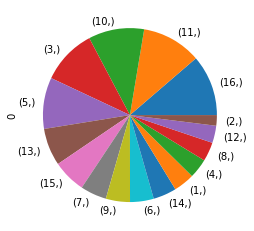

In [23]:
c.plot.pie(y=0, legend=False)

In [24]:
]

SyntaxError: unmatched ']' (<ipython-input-24-481b8b7ed782>, line 1)

In [ ]:
%%time

from sklearn.preprocessing import LabelBinarizer


lb = LabelBinarizer()
yyy_train = lb.fit_transform(yy_train)
yyy_test = lb.fit_transform(yy_test)

for e in test:
    e['label'] = lb.transform([e['label']])
    e['data'] = np.array(e['data'])
    
# for e in train:
#     e['label'] = lb.transform([e['label']])
#     e['data'] = np.array(e['data'])

In [ ]:
print(XX_train.shape)
print(yyy_train.shape)
print(XX_test.shape)
print(yyy_test.shape)

# Building Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

def build_model(shape, classes):
    model = Sequential()
    
    ncount = shape[0]*shape[1]
    
    model.add(Flatten(input_shape=shape))
    
    model.add(Dropout(drop_count))
    model.add(BatchNormalization())
    
    for i in range(1,layer_count):
        neurons = int(ncount/pow(dense_steps,i))
        if neurons <= classes*dense_steps:
            break
        model.add(Dropout(drop_count*i))
        model.add(Dense(neurons, activation='relu', 
                        kernel_regularizer=l2(0.001))
                 )
    
    model.add(Dense(classes, activation='softmax'))
    
    model.compile(
        optimizer=Adam(),
        loss="categorical_crossentropy", 
        metrics=["acc"],
    )
    
    return model



In [ ]:
checkpoint_file = './goat.weights'

def train_model(X_train, y_train, X_test, y_test):
    model = build_model(X_train[0].shape, 16)
    
    model.summary()
    
    # Create a callback that saves the model's weights
    model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='loss', 
			save_best_only=True)
    
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.0001)

    callbacks = [model_checkpoint, reduce_lr]
    
    history = model.fit(X_train, 
                        y_train,
                        epochs=50,
                        batch_size=32,
                        verbose=2,
                        validation_data=(X_test, y_test),
                        callbacks=callbacks
             )
    
    model.load_weights(checkpoint_path)
    return model, history


In [ ]:
%%time

model, history = train_model(np.array(XX_train), np.array(yyy_train), np.array(XX_test), np.array(yyy_test))

# Eval

In [ ]:
def predict(model, entry):
    p_dict = dict()
    predictions = np.argmax(model.predict(entry['data']), axis=-1)
    for p in predictions:
        if p in p_dict:
            p_dict[p] += 1
        else:
            p_dict[p] = 1
    prediction = max(p_dict, key=p_dict.get)
    return prediction+1

In [ ]:
%%time

ltest = [lb.inverse_transform(e['label'])[0] for e in test]
ptest = [predict(model, e) for e in test]
# for e in test:
#     print(f"Label:      {lb.inverse_transform(e['label'])[0]:2d}")
#     print(f"Prediction: {predict(model, e):2d}\n_______________")

In [ ]:
%%time

ltrain = [lb.inverse_transform(e['label'])[0] for e in train]
ptrain = [predict(model, e) for e in train]

# for e in train:
#     print(f"Label:      {lb.inverse_transform(e['label'])[0]:2d}")
#     print(f"Prediction: {predict(model, e):2d}\n_______________")


In [ ]:
%%time

from sklearn.metrics import confusion_matrix
import seaborn as sn

from sklearn.metrics import classification_report

set_digits = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15 }

train_cm = confusion_matrix(ltrain, ptrain, normalize='true')
test_cm = confusion_matrix(ltest, ptest, normalize='true')

df_cm = pd.DataFrame(test_cm, index=set_digits, columns=set_digits)
plt.figure(figsize = (10,7))
sn_plot = sn.heatmap(df_cm, annot=True, cmap="Greys")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

print(classification_report(ltest, ptest, zero_division=0))

In [ ]:
print(f'cenario: {cenario}')
print(f'win_sz: {win_sz}')
print(f'stride_sz: {stride_sz}')
print(f'dense_steps: {dense_steps}')
print(f'layer_count: {layer_count}')
print(f'drop_count: {drop_count}')